In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import json

outs = {}


for filename in sorted([f for f in glob.glob("../output/*.json") if "test" not in f]): 
    model_name = os.path.basename(filename).split(".")[0]
    print(model_name)
    with open(filename) as f:
        outs[model_name] = json.load(f)
        print(len(outs[model_name]["hate"]))

bertin
15
beto-cased-10000
15
beto-cased-20000
15
beto-cased-2500
15
beto-cased-5000
15
beto-cased
15
beto-uncased-10000
15
beto-uncased-20000
15
beto-uncased-2500
15
beto-uncased-5000
15
beto-uncased
15
roberta-bne
15
robertuito-cased
15
robertuito-deacc
15
robertuito-uncased-200k
5
robertuito-uncased
15


## Barplots

In [2]:
import pandas as pd

models = [
    "beto-uncased", "beto-uncased-2500", "beto-uncased-5000", "beto-uncased-10000", "beto-uncased-20000",
    "beto-cased", "beto-cased-2500", "beto-cased-5000", "beto-cased-10000", "beto-cased-20000",
    "robertuito-uncased", "robertuito-cased", "robertuito-deacc",
]
task_metrics = {
    "context_hate": "eval_mean_f1",
    "hate": "eval_macro_f1",
    "sentiment": "eval_macro_f1",
    "emotion": "eval_macro_f1",
    "irony": "eval_macro_f1",
}

dfs = []

for model in models: 
    model_df = pd.DataFrame({
        task: [run[column] for run in outs[model][task]]
        for task, column in task_metrics.items()
    })

    model_df["model"] = model
    model_df["case"] = "cased" if "-cased" in model else "uncased" 
    dfs.append(model_df)

df = pd.concat(dfs)

In [3]:
melted_df = df.melt(id_vars=["model", "case"], var_name="task", value_name="score")

melted_df

,model,case,task,score
0,beto-uncased,uncased,context_hate,0.581554
1,beto-uncased,uncased,context_hate,0.595540
2,beto-uncased,uncased,context_hate,0.585625
3,beto-uncased,uncased,context_hate,0.596017
4,beto-uncased,uncased,context_hate,0.588969
...,...,...,...,...
970,robertuito-deacc,uncased,irony,0.738641
971,robertuito-deacc,uncased,irony,0.741064
972,robertuito-deacc,uncased,irony,0.751901
973,robertuito-deacc,uncased,irony,0.737156


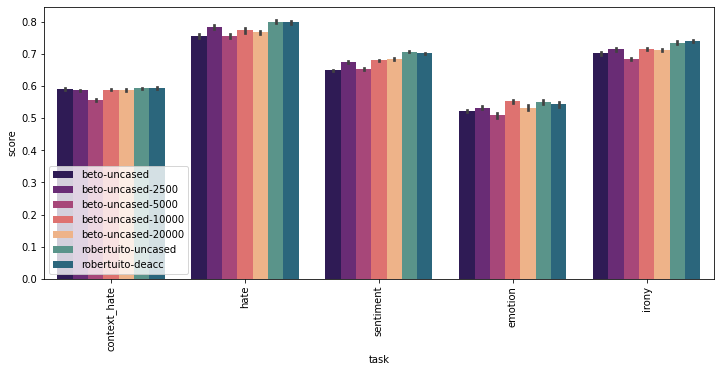

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

uncased_models = melted_df[melted_df.case == "uncased"]

palette= sns.color_palette("magma", 5) + sns.color_palette("crest", 2)

sns.barplot(
    x="task", y="score", hue="model", data=uncased_models,
    palette=palette,
)

plt.legend(loc="lower left")
plt.xticks(rotation=90) 

plt.savefig("img/results_uncased_models.pdf", bbox_inches="tight")

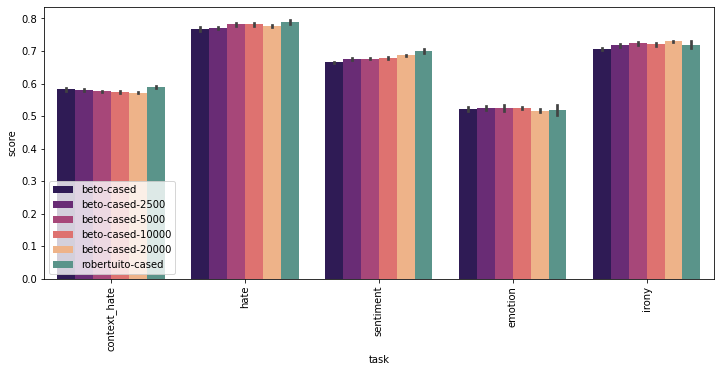

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

cased_models = melted_df[melted_df.case == "cased"]

ax = sns.barplot(
    x="task", y="score", hue="model", data=cased_models,
    palette=palette,
)

plt.legend(loc="lower left")
plt.xticks(rotation=90)

plt.savefig("img/results_cased_models.pdf", bbox_inches="tight")

In [11]:
import pandas as pd
import numpy as np

resume = []
mean_resume = []
task_metrics = {
    "context_hate": ["eval_mean_f1", "eval_hate_f1"],
    "hate": ["eval_hateful_f1", "eval_macro_f1"],
    "sentiment": ["eval_macro_f1", "eval_micro_f1"],
    "emotion": ["eval_macro_f1", "eval_micro_f1"],
    "irony": ["eval_ironic_f1", "eval_macro_f1"],
}

    
for model_name, output in outs.items():
    line = {
        "model": model_name, 
    }

    mean_line = {
        "model": model_name,
    }

    for task, metrics in task_metrics.items():
        try:
            for metric in metrics:
                arr = np.array([evaluation[metric] for evaluation in output[task]])
                metric_name = metric.replace("eval_", "")
                mean_line[task+" "+metric_name] = arr.mean()
                line[task+" "+metric_name] = f"{arr.mean():.3f} +- {arr.std():.3f}"
        except KeyError as e:
            print(e, "not in ", model_name)
            continue
    resume.append(line)
    mean_resume.append(mean_line)

order = [
    "bertin",
    "roberta-bne",
    "beto-uncased",
    # Nos quedamos con uncased-10000 que es el mejor
    #"beto-uncased-2500",
    #"beto-uncased-5000",
    "beto-uncased-10000",
    #"beto-uncased-20000",
    "robertuito-uncased",
    #"robertuito-deacc-288k",
    #"robertuito-deacc-344k",
    #"robertuito-deacc-400k",
    #"robertuito-deacc-440k",
    #"robertuito-deacc-490k",
    #"robertuito-deacc-510k",
    #"robertuito-deacc-540k",
    #"robertuito-deacc-576k",
    #"robertuito-deacc-592k",
    "robertuito-deacc",
    #"checkpoint-46k",
    #"checkpoint-62k",
    #"checkpoint-87k",
    #"checkpoint-100k",
    #"checkpoint-124k",
    #"robertuito-uncased-200k",
    "beto-cased",
    #"beto-cased-2500",
    #"beto-cased-5000",
    #"beto-cased-10000",
    "beto-cased-20000",
    "robertuito-cased",
]


df = pd.DataFrame(resume)
df.set_index("model", inplace=True)

df_mean = pd.DataFrame(mean_resume).set_index("model")
score_cols = ["context_hate mean_f1", "hate macro_f1", "sentiment macro_f1", "emotion macro_f1", "irony macro_f1"]
score_without_chate_cols = ["hate macro_f1", "sentiment macro_f1", "emotion macro_f1", "irony macro_f1"]

df.loc[order, "score"] = df_mean.loc[order, score_cols].mean(axis=1)
df.loc[order, "score2"] = df_mean.loc[order, score_without_chate_cols].mean(axis=1)
columns = [c for c in df.columns if "micro" not in c and "score" not in c] + ["score", "score2" ]

df.loc[order, score_cols + ["score", "score2"]].sort_values("score", ascending=False)

,context_hate mean_f1,hate macro_f1,sentiment macro_f1,emotion macro_f1,irony macro_f1,score,score2
model,,,,,,,
robertuito-uncased,0.593 +- 0.004,0.801 +- 0.010,0.707 +- 0.004,0.551 +- 0.011,0.736 +- 0.008,0.677629,0.698730
robertuito-deacc,0.593 +- 0.006,0.798 +- 0.008,0.702 +- 0.004,0.543 +- 0.015,0.740 +- 0.006,0.675293,0.695832
robertuito-cased,0.590 +- 0.005,0.790 +- 0.012,0.701 +- 0.012,0.519 +- 0.032,0.719 +- 0.023,0.663642,0.682176
beto-uncased-10000,0.588 +- 0.003,0.775 +- 0.015,0.680 +- 0.004,0.553 +- 0.009,0.717 +- 0.005,0.662637,0.681176
beto-cased-20000,0.572 +- 0.006,0.777 +- 0.009,0.686 +- 0.005,0.517 +- 0.009,0.730 +- 0.004,0.656487,0.677497
roberta-bne,0.577 +- 0.004,0.766 +- 0.015,0.669 +- 0.006,0.533 +- 0.011,0.723 +- 0.017,0.653565,0.672630
beto-cased,0.582 +- 0.007,0.768 +- 0.012,0.665 +- 0.004,0.521 +- 0.012,0.706 +- 0.007,0.648465,0.665093
bertin,0.557 +- 0.008,0.767 +- 0.005,0.665 +- 0.003,0.518 +- 0.012,0.716 +- 0.008,0.644702,0.666642
beto-uncased,0.591 +- 0.006,0.757 +- 0.012,0.649 +- 0.005,0.521 +- 0.006,0.702 +- 0.008,0.643817,0.657089


In [12]:
print(df.loc[order, score_cols + ["score"]].sort_values("score").to_markdown())

| model              | context_hate mean_f1   | hate macro_f1   | sentiment macro_f1   | emotion macro_f1   | irony macro_f1   |    score |
|:-------------------|:-----------------------|:----------------|:---------------------|:-------------------|:-----------------|---------:|
| beto-uncased       | 0.591 +- 0.006         | 0.757 +- 0.012  | 0.649 +- 0.005       | 0.521 +- 0.006     | 0.702 +- 0.008   | 0.643817 |
| bertin             | 0.557 +- 0.008         | 0.767 +- 0.005  | 0.665 +- 0.003       | 0.518 +- 0.012     | 0.716 +- 0.008   | 0.644702 |
| beto-cased         | 0.582 +- 0.007         | 0.768 +- 0.012  | 0.665 +- 0.004       | 0.521 +- 0.012     | 0.706 +- 0.007   | 0.648465 |
| roberta-bne        | 0.577 +- 0.004         | 0.766 +- 0.015  | 0.669 +- 0.006       | 0.533 +- 0.011     | 0.723 +- 0.017   | 0.653565 |
| beto-cased-20000   | 0.572 +- 0.006         | 0.777 +- 0.009  | 0.686 +- 0.005       | 0.517 +- 0.009     | 0.730 +- 0.004   | 0.656487 |
| beto-uncased-10000

In [5]:
import pandas as pd
import numpy as np

resume = []
mean_resume = []
task_metrics = {
    "context_hate": ["eval_mean_f1", "eval_hate_f1"],
    "hate": ["eval_hateful_f1", "eval_macro_f1"],
    "sentiment": ["eval_macro_f1", "eval_micro_f1"],
    "emotion": ["eval_macro_f1", "eval_micro_f1"],
}

    
for model_name, output in outs.items():
    line = {
        "model": model_name, 
    }

    mean_line = {
        "model": model_name,
    }

    for task, metrics in task_metrics.items():
        try:
            for metric in metrics:
                arr = np.array([evaluation[metric] for evaluation in output[task]])
                metric_name = metric.replace("eval_", "")
                mean_line[task+" "+metric_name] = arr.mean()
                line[task+" "+metric_name] = f"{arr.mean():.4f} +- {arr.std():.3f}"
        except KeyError as e:
            print(e, "not in ", model_name)
            continue
    resume.append(line)
    mean_resume.append(mean_line)

order = [
    "bertin",
    "beto-cased",
    "beto-uncased",
    "beto-ft-1000",
    "beto-ft-2000",
    "beto-uncased-1000",
    "beto-uncased-2000",
    "beto-uncased-5000",
    "beto-uncased-5000-grito",
    "beto-uncased-4000-tpu",
    "beto-uncased-5000-tpu",
    "beto-uncased-15000",
    "beto-uncased-15000-last",
    "beto-cased-15000",
]


df = pd.DataFrame(resume)
df.set_index("model", inplace=True)

df_mean = pd.DataFrame(mean_resume).set_index("model")
score_cols = ["context_hate mean_f1", "hate hateful_f1", "sentiment macro_f1", "emotion macro_f1"]

df.loc[order, "score"] = df_mean.loc[order, score_cols].mean(axis=1)
columns = [c for c in df.columns if "micro" not in c]

df.loc[order, columns]

,context_hate mean_f1,context_hate hate_f1,hate hateful_f1,hate macro_f1,sentiment macro_f1,emotion macro_f1,score
model,,,,,,,
bertin,0.5443 +- 0.005,0.6613 +- 0.009,0.7270 +- 0.013,0.7539 +- 0.013,0.6650 +- 0.002,0.5245 +- 0.026,0.615193
beto-cased,0.5870 +- 0.007,0.6884 +- 0.005,0.7408 +- 0.013,0.7554 +- 0.021,0.6617 +- 0.005,0.5246 +- 0.016,0.628539
beto-uncased,0.5906 +- 0.004,0.6856 +- 0.006,0.7305 +- 0.006,0.7455 +- 0.014,0.6517 +- 0.002,0.5250 +- 0.014,0.624442
beto-ft-1000,0.5857 +- 0.003,0.6861 +- 0.002,0.7552 +- 0.011,0.7786 +- 0.012,0.6721 +- 0.001,0.5335 +- 0.012,0.636610
beto-ft-2000,0.5848 +- 0.005,0.6865 +- 0.003,0.7486 +- 0.003,0.7691 +- 0.010,0.6751 +- 0.005,0.5257 +- 0.010,0.633550
beto-uncased-1000,0.5950 +- 0.003,0.6934 +- 0.002,0.7451 +- 0.004,0.7703 +- 0.004,0.6717 +- 0.005,0.5364 +- 0.009,0.637067
beto-uncased-2000,0.5989 +- 0.004,0.6954 +- 0.002,0.7575 +- 0.009,0.7729 +- 0.015,0.6812 +- 0.001,0.5354 +- 0.005,0.643223
beto-uncased-5000,0.5788 +- 0.001,0.6775 +- 0.004,0.7623 +- 0.002,0.7854 +- 0.000,0.6748 +- 0.004,0.5399 +- 0.006,0.638945
beto-uncased-5000-grito,0.5848 +- 0.008,0.6866 +- 0.009,0.7615 +- 0.006,0.7738 +- 0.010,0.6865 +- 0.005,0.5522 +- 0.003,0.646247


- "last" es usando los mismos parámetros que en el paper de finetuning

No parecen ser los mejores!
